# Setup

## Packages

In [ ]:
# data analysis
import pandas as pd
import numpy as np
import scanpy as sc

# cell-cell communication
import liana as li
import cell2cell as c2c

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from plotnine.options import set_option
from collections import defaultdict

# readability
import warnings

warnings.filterwarnings("ignore")

set_option("limitsize", False)

True

In [ ]:
# NOTE: to use CPU instead of GPU, set use_gpu = False
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        tl.set_backend("pytorch")
else:
    device = "cpu"

device

'cuda'

## Functions

### Scatterplots

#### Embedding shuffled

In [ ]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 500000 / adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

## Colors

In [ ]:
colors = [
    "#66c5cc",
    "#f6cf71",
    "#f89c74",
    "#dcb0f2",
    "#87c55f",
    "#9eb9f3",
    "#fe88b1",
    "#c9db74",
    "#8be0a4",
    "#b497e7",
    "#d3b484",
    "#b3b3b3",
    "#89fade",
    "#817157",
    "#132b58",
]
leiden_colors = {f"{i}": colors[i] for i in range(15)}

In [ ]:
timepoint_colors = {
    "P1": "#bf812d",
    "P7": "#dfc27d",
    "P90-100": "#01665e",
}

## Dataset

In [ ]:
data_path = "/path/to/data/"

In [ ]:
adata = sc.read_h5ad(f"{data_path}wildling_germfree_cleaned.h5ad")

# Ligand-Receptor inference by sample

## Running Liana

In [ ]:
sample_key = "replicate"
condition_key = "microbiota_status"
groupby = "cell_type"

In [ ]:
adata.X = adata.layers['log1p_norm'].copy()

In [ ]:
adata = adata[adata.obs['replicate'] != 'germfree_p7_3'].copy()

In [ ]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    resource_name="mouseconsensus",
    sample_key=sample_key,  # sample key by which we which to loop
    use_raw=False,
    verbose='full',  # use 'full' to show all verbose information
    n_perms=None,  # exclude permutations for speed, also excludes some methods like cellchat I think, but not changing it doesn't work
    return_all_lrs=True,  # return all LR values
)

In [ ]:
from liana.method import (
    singlecellsignalr,
    connectome,
    cellphonedb,
    natmi,
    logfc,
    cellchat,
    geometric_mean,
)

In [ ]:
methods = [
    logfc,
    geometric_mean,
    singlecellsignalr,
    connectome,
    cellphonedb,
    natmi,
    cellchat,
]
new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [ ]:
new_rank_aggregate.by_sample(
    adata,
    sample_key=sample_key,
    groupby=groupby,
    resource_name="mouseconsensus",
    use_raw=False,
    verbose=True,
    inplace=True,
    return_all_lrs=True,
)

## 4D Tensor

### Buidling tensor from liana

In [ ]:
tensor = li.multi.to_tensor_c2c(
    adata,
    sample_key=sample_key,
    score_key="magnitude_rank",  # can be any score from liana
    how="outer",  # how to join the samples,
    context_order=[
        "germfree_p1_1",
        "germfree_p1_2",
        "germfree_p1_3",
        "spf_p1_1",
        "spf_p1_2",
        "spf_p1_3",
        "wildling_p1_1",
        "wildling_p1_2",
        "wildling_p1_3",
        "germfree_p7_1",
        "germfree_p7_2",
        "spf_p7_1",
        "spf_p7_2",
        "spf_p7_3",
        "wildling_p7_1",
        "wildling_p7_2",
        "wildling_p7_3",
        "germfree_p90_1",
        "germfree_p90_2",
        "germfree_p90_3",
        "spf_p90_1",
        "spf_p90_2",
        "spf_p90_3",
        "spf_p100_1",
        "spf_p100_2",
        "spf_p100_3",
        "wildling_p100_1",
        "wildling_p100_2",
        "wildling_p100_3",
    ],
)

In [ ]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: "Unknown", context_dict)

In [ ]:
tensor_meta = c2c.tensor.generate_tensor_metadata(
    interaction_tensor=tensor,
    metadata_dicts=[context_dict, None, None, None],
    fill_with_order_elements=True,
)

Running Tensor Cell2cell. The first time with rank=None returned 7 as the optimal rank. to keep computation time down, I will set rank 7 as the rank when rerunning this script.

### Tensor decomposition

In [ ]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(
    tensor,
    tensor_meta,
    copy_tensor=True,
    rank=7,
    tf_optimization="robust",
    random_state=0,
    device=device,
    elbow_metric="error",
    smooth_elbow=False,
    upper_rank=10,
    tf_init="svd",
    tf_svd="numpy_svd",
    cmaps=None,
    sample_col="Element",
    group_col="Category",
    output_fig=True,
)

plt.show()

# Figures

In [ ]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
        'figure.dpi': 200
    }
)

## Colors

In [ ]:
replicate_to_ms = {
        "germfree_p1_1" : "germfree",
        "germfree_p1_2" : "germfree",
        "germfree_p1_3" : "germfree",
        "spf_p1_1": "spf",
        "spf_p1_2": "spf",
        "spf_p1_3": "spf",
        "wildling_p1_1": "wildling",
        "wildling_p1_2": "wildling",
        "wildling_p1_3": "wildling",
        "germfree_p7_1" : "germfree",
        "germfree_p7_2" : "germfree",
        "spf_p7_1": "spf",
        "spf_p7_2": "spf",
        "spf_p7_3": "spf",
        "wildling_p7_1": "wildling",
        "wildling_p7_2": "wildling",
        "wildling_p7_3": "wildling",
        "germfree_p90_1" : "germfree",
        "germfree_p90_2" : "germfree",
        "germfree_p90_3" : "germfree",
        "spf_p90_1": "spf",
        "spf_p90_2": "spf",
        "spf_p90_3": "spf",
        "spf_p100_1": "spf",
        "spf_p100_2": "spf",
        "spf_p100_3": "spf",
        "wildling_p100_1": "wildling",
        "wildling_p100_2": "wildling",
        "wildling_p100_3": "wildling",
}

In [ ]:
microbiota_status_colors = {
    'germfree': '#1b9e77',
    'spf': '#d95f02',
    'wildling': '#7570b3',
}

In [ ]:
cell_type_colors = {
    "DETC cycling": "#a6cee3",
    "DETC mature": "#1f78b4",
    "DETC cytotoxic": "#0099a8",
    "LC cycling": "#fb9a99",
    "LC immature": "#fdbf6f",
    "LC maturing": "#ff7f00",
    "LC mature": "#e31a1c",
}

In [ ]:
replicate_ms_colors = (
    pd.DataFrame.from_dict(replicate_to_ms, orient="index", columns=["ms"])[
        "ms"
    ]
    .map(microbiota_status_colors)
    .to_dict()
)

In [ ]:
replicate_to_timepoint = {
    "germfree_p1_3": "P1",
    "germfree_p1_2": "P1",
    "germfree_p1_1": "P1",
    "germfree_p7_3": "P7",
    "germfree_p7_1": "P7",
    "germfree_p7_2": "P7",
    "germfree_p90_3": "P90-100",
    "germfree_p90_1": "P90-100",
    "germfree_p90_2": "P90-100",
    "spf_p1_3": "P1",
    "spf_p1_2": "P1",
    "spf_p1_1": "P1",
    "spf_p90_3": "P90-100",
    "spf_p90_1": "P90-100",
    "spf_p90_2": "P90-100",
    "spf_p7_3": "P7",
    "spf_p7_1": "P7",
    "spf_p7_2": "P7",
    "spf_p100_3": "P90-100",
    "spf_p100_1": "P90-100",
    "spf_p100_2": "P90-100",
    "wildling_p1_3": "P1",
    "wildling_p1_2": "P1",
    "wildling_p1_1": "P1",
    "wildling_p7_3": "P7",
    "wildling_p7_1": "P7",
    "wildling_p7_2": "P7",
    "wildling_p100_3": "P90-100",
    "wildling_p100_1": "P90-100",
    "wildling_p100_2": "P90-100",
}

In [ ]:
replicate_tp_colors = (
    pd.DataFrame.from_dict(
        replicate_to_timepoint, orient="index", columns=["timepoint"]
    )["timepoint"]
    .map(timepoint_colors)
    .to_dict()
)

In [ ]:
factors = tensor.factors

## Boxplot Contexts

### Microbiota

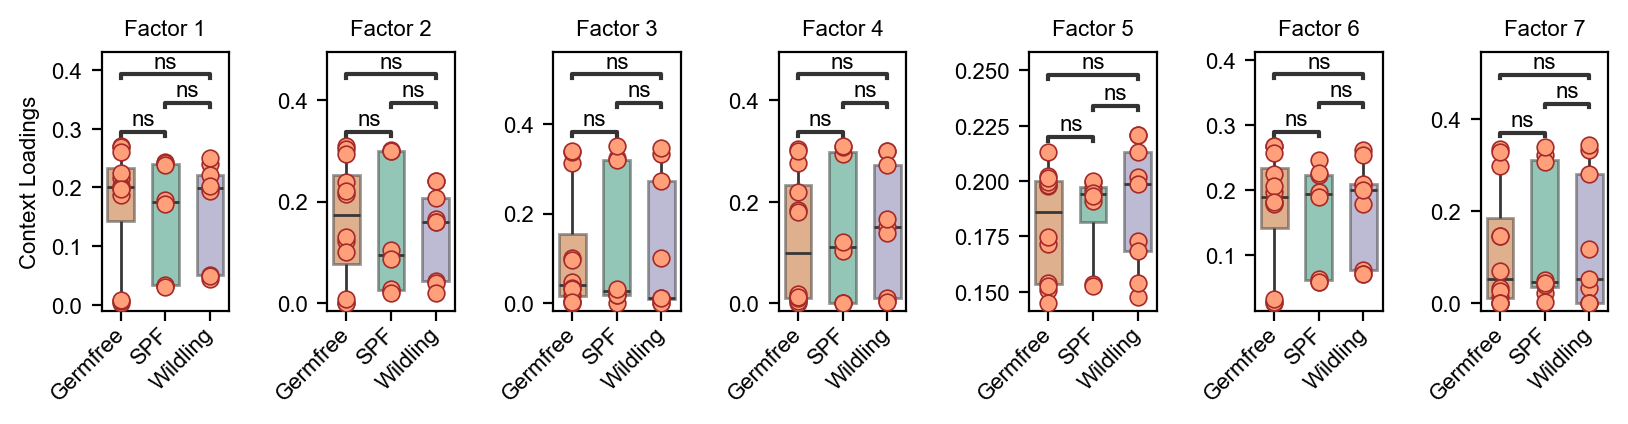

In [ ]:
fig, axes = c2c.plotting.context_boxplot(
    context_loadings=factors["Contexts"],
    metadict=context_dict,
    nrows=1,
    figsize=(203.841/25.4, 51/25.4),
    statistical_test="t-test_ind",
    pval_correction="fdr_bh",
    cmap=microbiota_status_colors,
    verbose=False,
)

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)

    ax.set_xticklabels(['Germfree', 'SPF', 'Wildling'], va='center', )

plt.subplots_adjust(wspace=0.)
fig.set_constrained_layout(True)

# Supplementary figures

## Boxplots

### Timepoint

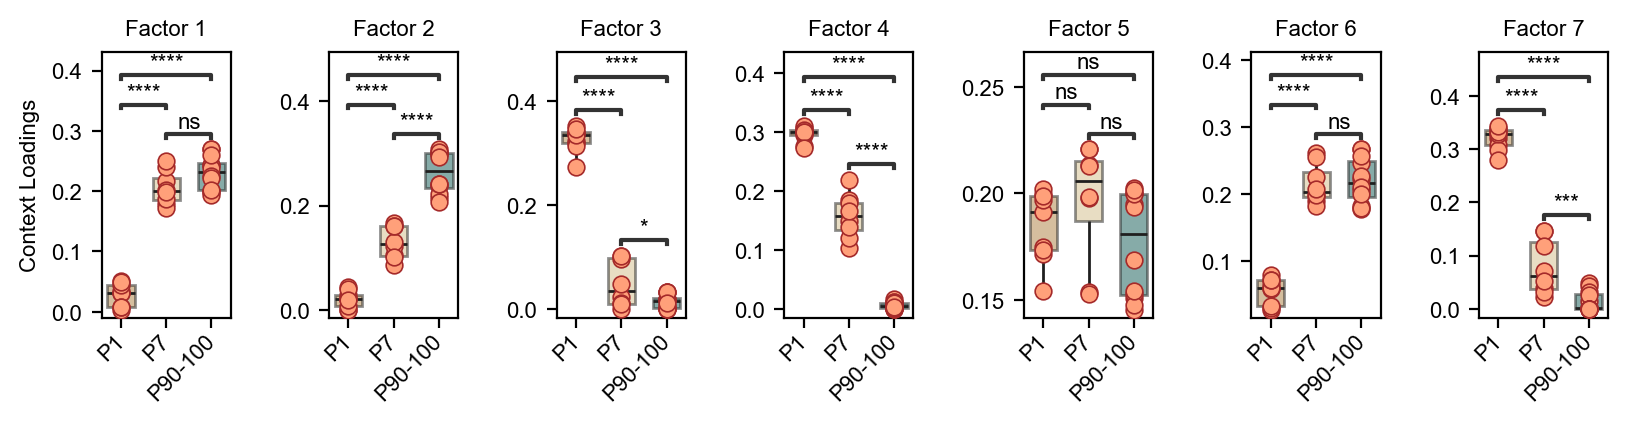

In [ ]:
fig, axes = c2c.plotting.context_boxplot(
    context_loadings=factors["Contexts"],
    metadict=replicate_to_timepoint,
    nrows=1,
    figsize=(203.841/25.4, 51/25.4),
    statistical_test="t-test_ind",
    pval_correction="fdr_bh",
    cmap=timepoint_colors,
    verbose=False,
)

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)

    ax.set_xticklabels(ax.get_xticklabels(), va='center', )

    ax.invert_xaxis()

plt.subplots_adjust(wspace=0.)
fig.set_constrained_layout(True)

## Barplots

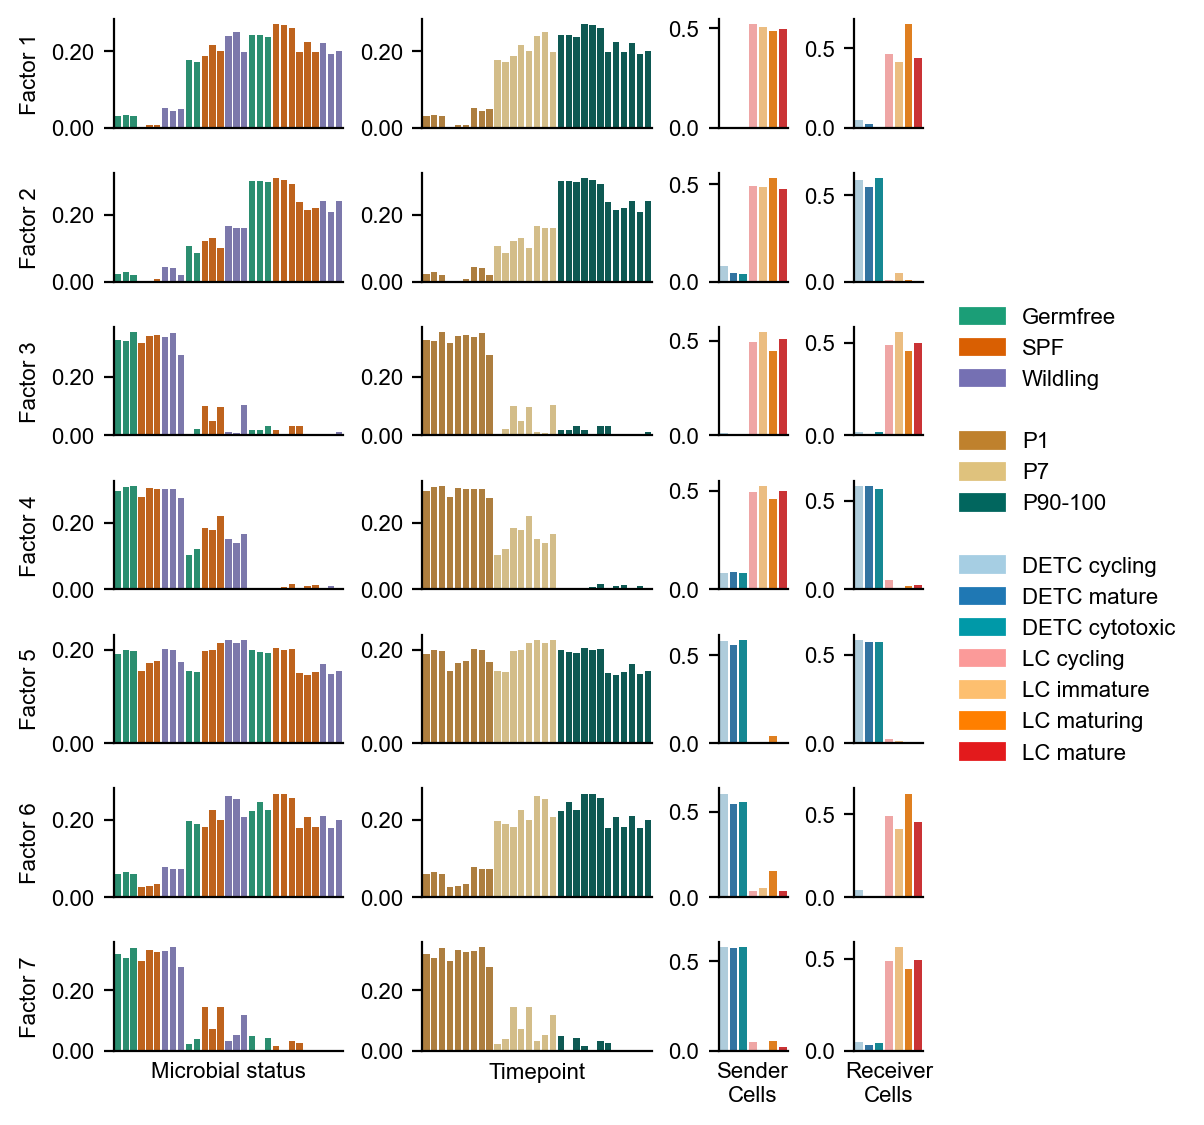

In [ ]:
cell_type_order = [
    "DETC cycling",
    "DETC mature",
    "DETC cytotoxic",
    "LC cycling",
    "LC immature",
    "LC maturing",
    "LC mature",
]

contexts = factors["Contexts"]
lr_pairs = factors["Ligand-Receptor Pairs"]
sender_cells = factors["Sender Cells"].reindex(cell_type_order)
receiver_cells = factors["Receiver Cells"].reindex(cell_type_order)

fig = plt.figure(figsize=(150/25.4, 140/25.4), dpi=200, layout="constrained")

gs = gridspec.GridSpec(7, 5, figure=fig, width_ratios=[5, 5, 1.5, 1.5, 3])

for i, context in enumerate(contexts.keys()):
    ax = fig.add_subplot(gs[i, 0])

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    sns.barplot(data=contexts.loc[:, context], palette=replicate_ms_colors)

    ax.set_ylabel(
        context,
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticklabels([])
    ax.set_xticks([])

    if context == "Factor 7":
        ax.set_xlabel("Microbial status")

for i, context in enumerate(contexts.keys()):
    ax = fig.add_subplot(gs[i, 1])

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    sns.barplot(data=contexts.loc[:, context], palette=replicate_tp_colors)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticklabels([])
    ax.set_xticks([])

    if context == "Factor 7":
        ax.set_xlabel("Timepoint")

for i, sender_cell in enumerate(sender_cells.keys()):
    ax = fig.add_subplot(gs[i, 2])

    sns.barplot(data=sender_cells.loc[:, sender_cell], palette=cell_type_colors)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if sender_cell == "Factor 7":
        ax.set_xlabel("Sender\nCells")

for i, receiver_cell in enumerate(receiver_cells.keys()):
    ax = fig.add_subplot(gs[i, 3])

    sns.barplot(data=receiver_cells.loc[:, receiver_cell], palette=cell_type_colors)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    if receiver_cell == "Factor 7":
        ax.set_xlabel("Receiver\nCells")

legend_ax = fig.add_subplot(gs[:, 4])

ms_patches = [
    mpatches.Patch(color=color, label=label) for label, color in zip(['Germfree', 'SPF', 'Wildling'], microbiota_status_colors.values())
]

tp_patches = [
    mpatches.Patch(color=color, label=label) for label, color in timepoint_colors.items()
]

celltype_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in cell_type_colors.items()
]

legend_ax.axis("off")

legend_ax.legend(
    handles=(
        ms_patches
        + [mpatches.Patch(color="none", label="")]
        + tp_patches 
        + [mpatches.Patch(color="none", label="")]
        + celltype_patches
    ),
    title=None,
    loc="center left",
    frameon=False,
)

plt.show()